In [26]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Constant

In [1]:
# Constants
TEST_DATA_DIR = 'data/test'
TRAIN_DATA_DIR = 'raw-data/train'
METADATA_PATH = 'raw-data/train.csv'

IMG_WIDTH = 32
IMG_HEIGTH = 32
BATCH_SIZE = 32
EPOCHS = 15

# Load augment & preprocess data

In [3]:
# Load labels
metadata = pd.read_csv(METADATA_PATH)
metadata.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [6]:
# TODO: De geaugmente afbeeldingen kunnen gebruikt worden tijdens het trainen en daarna tijdens het testen. Dit kan voor overfitting zorgen.

train_data = []

for index, row in metadata.iterrows():
    image = cv2.imread(f'{TRAIN_DATA_DIR}/{row.id}')
    label = 'has_cactus' if row.has_cactus else "no_cactus" 
    train_data.append({'image': image, 'label': label})

    # Augment 30% of the data
    if np.random.random() < 0.3:
        # Horizontal or vertical flip
        flag = np.random.randint(0, 1)
        image = cv2.flip(image, flag)
        train_data.append({'image': image, 'label': label})
        
# Convert to numpy array in order to shuffle the data
train_data = np.asarray(train_data)
np.random.shuffle(train_data)
print(len(train_data))

22706


In [11]:
# Split into lists of images and labels
X =  [x['image'] for x in train_data]
y = [x['label'] for x in train_data]

# Encode label
encoder = LabelBinarizer()
y = encoder.fit_transform(y)
# Horizontally stack the array to get it into the correct shape
y = np.hstack((y, 1 - y))

# Split into training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Convert to numpy arrays for Keras
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Build model

In [12]:
# Build VGG model.
def add_vgg_block(model, n_filters, n_conv):
    # Add conv layers
    for _ in range(n_conv):
        model.add(Conv2D(n_filters, (3, 3), padding='same', activation='relu'))
    # Add max pooling layers
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    return model

In [16]:
input_layer = Input(shape=(IMG_HEIGTH, IMG_WIDTH, 3))

vgg_model = Sequential()
vgg_model.add(input_layer)
vgg_model = add_vgg_block(vgg_model, 64, 2)
vgg_model.add(Flatten())
vgg_model.add(Dense(2, activation='softmax'))
vgg_model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 32770     
Total params: 71,490
Trainable params: 71,490
Non-trainable params: 0
_________________________________________________________________


In [17]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#TODO: Hoe wordt de validate uitgevoerd? Recall precision.
vgg_history = vgg_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/15
568/568 [==============================] - 47s 82ms/step - loss: 1.1797 - accuracy: 0.9018
Epoch 2/15
568/568 [==============================] - 42s 74ms/step - loss: 0.1285 - accuracy: 0.9509
Epoch 3/15
568/568 [==============================] - 41s 72ms/step - loss: 0.1019 - accuracy: 0.9621
Epoch 4/15
568/568 [==============================] - 41s 72ms/step - loss: 0.0736 - accuracy: 0.9721
Epoch 5/15
568/568 [==============================] - 41s 72ms/step - loss: 0.0488 - accuracy: 0.9832
Epoch 6/15
568/568 [==============================] - 41s 72ms/step - loss: 0.0355 - accuracy: 0.9879
Epoch 7/15
568/568 [==============================] - 41s 72ms/step - loss: 0.0579 - accuracy: 0.9802
Epoch 8/15
568/568 [==============================] - 41s 73ms/step - loss: 0.1120 - accuracy: 0.9630
Epoch 9/15
568/568 [==============================] - 41s 72ms/step - loss: 0.0511 - accuracy: 0.9821
Epoch 10/15
568/568 [==============================] - 41s 72ms/step - loss: 0.037

# Evaluate

Text(0.5, 0, 'Epoch')

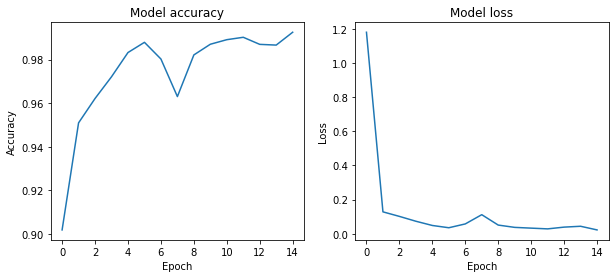

In [22]:
# Visualize model history
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(vgg_history.history['accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')

axes[1].plot(vgg_history.history['loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')

In [24]:
# Evaluate on test set
scores = vgg_model.predict(X_test)
predictions = np.argmax(scores, axis=1)

true = np.argmax(y_test, axis=1)

# inverse the encoding of the labels
predictions = encoder.inverse_transform(predictions)
true = encoder.inverse_transform(true)

In [28]:
labels = ['has_cactus', 'no_cactus']

df = pd.DataFrame(
    data=confusion_matrix(true, predictions, labels=labels),
    columns=labels,
    index=labels
)

df.head()

,has_cactus,no_cactus
has_cactus,1118,33
no_cactus,24,3367


In [33]:
# Calculate True Negative (tn), False Positive (fp), False Negative (fn) and True Positive (tp) 
tn, fp, fn, tp = confusion_matrix(true, predictions).ravel()

table = pd.DataFrame({'type': ['True Negative', 'False Positive', 'False Negative', 'True Positive'], 'value': [tn, fp, fn, tp]})

table.head()

,type,value
0,True Negative,1118
1,False Positive,33
2,False Negative,24
3,True Positive,3367


In [30]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = ((2 * recall) * precision) / (recall + precision)

print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Recall: 0.9929224417575936
Precision: 0.9902941176470588
F1 Score: 0.991606538065086


In [31]:
# Show images where the prediction was wrong
fn_images = []
fp_images = []

for index, (predicted_label, true_label) in enumerate(zip(predictions, true)):
    if str(predicted_label) == 'no_cactus' and str(true_label) == 'has_cactus':
        fn_images.append(X_test[index])

# Get Indices of False Positives
for index, (predicted_label, true_label) in enumerate(zip(predictions, true)):
    if str(predicted_label) == 'has_cactus' and str(true_label) == 'no_cactus':
        fp_images.append(X_test[index])

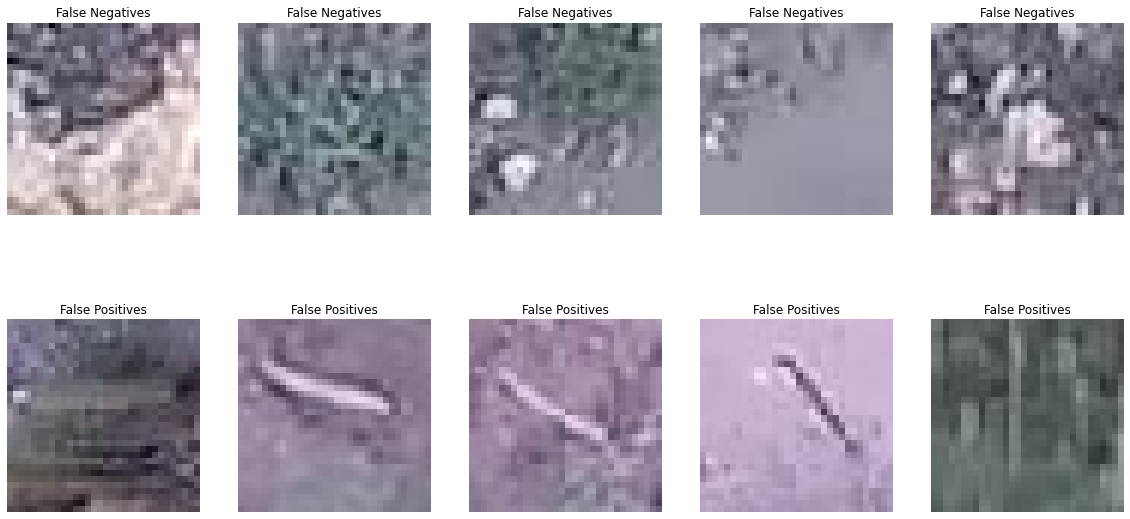

In [32]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
idx = np.random.randint(len(fn_images), size=5)

np.random.shuffle(fn_images)
np.random.shuffle(fp_images)

for index, img in enumerate(fn_images[:5]):
    axes[0, index].imshow(img)
    axes[0, index].axis('off')
    axes[0, index].set_title('False Negatives')

for index, img in enumerate(fp_images[:5]):
    axes[1, index].imshow(img)
    axes[1, index].axis('off')
    axes[1, index].set_title('False Positives')

# Export model

In [ ]:
vgg_model.save('models/vgg')